In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [3]:
#{"DX": [], "DY": [], "DZ": [], "H": [], "log_f": [], "RP": []})
DATA = pd.read_csv("../csv/data.csv")
DATA.pop("Unnamed: 0")

ROW_NUM = len(DATA.index)
print(ROW_NUM)
TRAINING_NUM = int(ROW_NUM / 10 * 7)
VALIDATION_NUM = int(ROW_NUM / 20 * 3 )

TRAINING_DATA = DATA.iloc[ :TRAINING_NUM,:]
VALIDATION_DATA = DATA.iloc[TRAINING_NUM:TRAINING_NUM+VALIDATION_NUM,:]
TEST_DATA = DATA.iloc[TRAINING_NUM+VALIDATION_NUM:,:]
TRAINING_VAL = pd.DataFrame(TRAINING_DATA.pop('RP'))
VALIDATION_VAL = pd.DataFrame(VALIDATION_DATA.pop('RP'))
TEST_VAL = pd.DataFrame(TEST_DATA.pop('RP'))

DATA.pop('RP')


452864


0        -117.750391
1         -69.327201
2        -106.181961
3        -112.981354
4        -128.770041
             ...    
452859   -135.552306
452860   -155.180482
452861   -105.433740
452862   -151.030553
452863   -179.902905
Name: RP, Length: 452864, dtype: float64

In [4]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
min_max_scaler.fit(DATA)
joblib.dump(min_max_scaler, "MLP.scaler.gz") 

TRAINING_DATA = min_max_scaler.transform(TRAINING_DATA)
TRAINING_DATA = pd.DataFrame(TRAINING_DATA)
VALIDATION_DATA = min_max_scaler.transform(VALIDATION_DATA)
VALIDATION_DATA = pd.DataFrame(VALIDATION_DATA)
TEST_DATA = min_max_scaler.transform(TEST_DATA)
TEST_DATA = pd.DataFrame(TEST_DATA)

In [8]:
model = keras.models.Sequential([
    keras.layers.Dense(640,activation="tanh", input_dim=5),
    keras.layers.Dense(1, activation="linear")
])

model.compile(loss="mean_squared_error", optimizer='adam')


Epoch 1/2000
3171/3171 [==============================] - 3s 940us/step - loss: 824.3884 - val_loss: 60.6976
Epoch 2/2000
3171/3171 [==============================] - 3s 864us/step - loss: 53.2759 - val_loss: 39.9080
Epoch 3/2000
3171/3171 [==============================] - 3s 826us/step - loss: 32.7127 - val_loss: 29.3465
Epoch 4/2000
3171/3171 [==============================] - 3s 844us/step - loss: 24.1571 - val_loss: 18.7856
Epoch 5/2000
3171/3171 [==============================] - 3s 853us/step - loss: 16.3760 - val_loss: 16.0691
Epoch 6/2000
3171/3171 [==============================] - 3s 874us/step - loss: 14.3043 - val_loss: 14.3312
Epoch 7/2000
3171/3171 [==============================] - 3s 935us/step - loss: 13.0901 - val_loss: 12.7169
Epoch 8/2000
3171/3171 [==============================] - 3s 895us/step - loss: 12.2343 - val_loss: 11.8781
Epoch 9/2000
3171/3171 [==============================] - 2s 764us/step - loss: 11.5479 - val_loss: 11.2869
Epoch 10/2000
3171/3171 [==

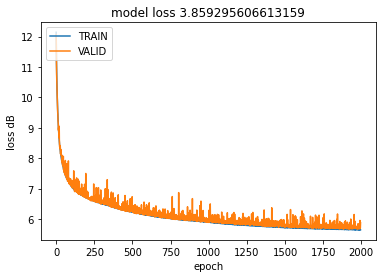

In [9]:
history = model.fit(TRAINING_DATA, TRAINING_VAL, epochs=2000, batch_size=100, validation_data=(VALIDATION_DATA, VALIDATION_VAL))
model.save("5-640-1_2000.h5")
from math import log10
scores = model.evaluate(TEST_DATA, TEST_VAL, batch_size=20)
plt.plot([10*log10(loss) for loss in history.history['loss'][4:]])
plt.plot([10*log10(loss) for loss in history.history['val_loss'][4:]])
plt.title(f'model loss {scores}')
plt.ylabel('loss dB')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VALID'], loc='upper left')
plt.savefig("5-640-1.png")
plt.show()


In [29]:
model.save("5-320-1_2000.h5")

In [1]:
from math import log10
scores = model.evaluate(TEST_DATA, TEST_VAL, batch_size=20)
plt.plot([10*log10(loss) for loss in history.history['loss'][4:]])
plt.plot([10*log10(loss) for loss in history.history['val_loss'][4:]])
plt.title(f'model loss {scores}')
plt.ylabel('loss dB')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VALID'], loc='upper left')
plt.savefig("5-320-1.png")
plt.show()

NameError: name 'model' is not defined

In [16]:
TEST_DATA = TEST_DATA.iloc[:30,:]
PREDICTIONS = pd.DataFrame(model.predict(TEST_DATA))
PREDICTIONS.columns=["PREDICITONS"]

TEST_VAL = TEST_VAL.iloc[:30,:]
TEST_VAL.columns=["TEST_VAL"]
TEST_VAL = TEST_VAL.reset_index(drop=True)

result=pd.concat([PREDICTIONS, TEST_VAL], axis=1)
result["ERROR"] = result["PREDICITONS"] - result["TEST_VAL"]
result.to_csv("MLP.csv")
